# scCODA - Compositional analysis of single-cell data



This notebook serves as a tutorial for using the *scCODA* package to analyze changes in cell composition data.

The package is intended to be used with data coming from single-cell RNA-seq experiments, however there are no 
restrictions that prevent the use of data from other sources.

The data we use in the following example comes from [*Haber et al. [2017]*](https://www.nature.com/articles/nature24489).
It contains samples from the small intestinal epithelium of mice with different conditions.


In [17]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pickle as pkl

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat



### Data preparation

In [18]:
# Load data

cell_counts = pd.read_csv("../data/haber_counts.csv")

print(cell_counts)

            Mouse  Endocrine  Enterocyte  Enterocyte.Progenitor  Goblet  Stem  \
0       Control_1         36          59                    136      36   239   
1       Control_2          5          46                     23      20    50   
2       Control_3         45          98                    188     124   250   
3       Control_4         26         221                    198      36   131   
4  H.poly.Day10_1         42          71                    203     147   271   
5  H.poly.Day10_2         40          57                    383     170   321   
6   H.poly.Day3_1         52          75                    347      66   323   
7   H.poly.Day3_2         65         126                    115      33    65   
8          Salm_1         37         332                    113      59    90   
9          Salm_2         32         373                    116      67   117   

    TA  TA.Early  Tuft  
0  125       191    18  
1   11        40     5  
2  155       365    33  
3  130  

Looking at the data, we see that we have 4 control samples, and 3 conditions with 2 samples each. 
To use the models in *scCODA*, we first have to convert the data into an [anndata](https://github.com/theislab/anndata) object.
This object separates our data components: Cell counts are stored in `data.X`, covariates in `data.obs`.

For our first example, we want to look at how the Salmonella infection influences the cell composition.



In [19]:
# Convert data to anndata object

# Filter out control and salmonella data
salm_indices = [0, 1, 2, 3, 8, 9]
salm_df = cell_counts.iloc[salm_indices, :]

# Convert to a CompositionalData object
data_salm = dat.from_pandas(salm_df, covariate_columns=["Mouse"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_salm.obs["Condition"] = data_salm.obs["Mouse"].str.replace(r"_[0-9]", "")
print(data_salm.X)
print(data_salm.obs)

[[ 36.  59. 136.  36. 239. 125. 191.  18.]
 [  5.  46.  23.  20.  50.  11.  40.   5.]
 [ 45.  98. 188. 124. 250. 155. 365.  33.]
 [ 26. 221. 198.  36. 131. 130. 196.   4.]
 [ 37. 332. 113.  59.  90.  47. 132.  10.]
 [ 32. 373. 116.  67. 117.  65. 168.  12.]]
       Mouse Condition
0  Control_1   Control
1  Control_2   Control
2  Control_3   Control
3  Control_4   Control
8     Salm_1      Salm
9     Salm_2      Salm


Plotting the data, we can see that there is a large increase of Enterocytes in the infected sampes, while most other cell types slightly decrease.
Since scRNA-seq experiments are limited in the number of cells per sample, the count data is compositional, which leads to negative correlations between the cell types.
Thus, the slight decreases in many cell types might be fully caused by the increase in Enterocytes.

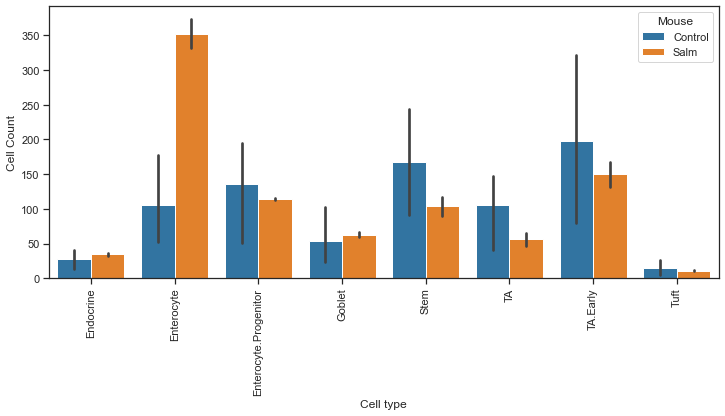

In [20]:
fig, ax = plt.subplots(figsize=(12,5))
df = pd.melt(salm_df, id_vars=['Mouse'], value_vars=salm_df.columns[1:])
sns.set_context('notebook')
sns.set_style('ticks')
d = sns.barplot(x='variable', y = 'value', hue=df["Mouse"].str.replace(r"_[0-9]", ""), data=df)
d.set_ylabel('Cell Count')
loc, labels = plt.xticks()
d.set_xticklabels(labels, rotation=90)
d.set_xlabel('Cell type')
plt.show()

*Note that the use of* anndata *in* scCODA *is different from the use in scRNA-seq pipelines, e.g.* scanpy.
*To convert* scanpy *objects to a scCODA dataset, have a look at `dat.from_scanpy_list`.*

### Model setup and inference

We can now create the model and run inference on it. The `mod.CompositionalAnalysis` class takes our data object and performs parameter inference on it.

The `formula` parameter specifies how the covariates are used in the model. It can process R-style formulas via the [patsy](https://patsy.readthedocs.io/en/latest/) package, e.g. `formula="Cov1 + Cov2 + Cov3"`.

The `reference_cell_type` parameter is used to specify a cell type that is left unchanged by the covariates.
This feature is optional, a reference cell type of `None` specifies the model without reference specification.
For now, we will use no reference cell type.

In [21]:
model_salm = mod.CompositionalAnalysis(data_salm, formula="Condition", reference_cell_type=None)

TypeError: __new__() got an unexpected keyword argument 'reference_cell_type'

HMC sampling can be performed by calling `sample_hmc()` on the model, which produces a `sccoda.util.result_classes.CAResult` object.

In [ ]:
# Run MCMC
sim_results = model_salm.sample_hmc()

### Result interpretation

Calling `summary()` on the results object, we can see all relevant information for further analysis:

In [ ]:
sim_results.summary()

**Model properties**

First, the summary shows an overview over the model properties: 
* Number of samples/cell types
* Index of the reference cell type, starting at 0.
* The formula used

The model has two types of parameters that are relevant for analysis - intercepts and effects. 
These can be interpreted like in a standard regression model:
Intercepts show how the cell types are distributed without any active covariates, effects show ho the covariates influence the cell types.

**Intercepts**

The first column of the intercept summary shows the parameters determined by the MCMC inference.

The "Expected sample" column gives some context to the numerical values. 
If we take the mean number of cells over all samples from our dataset, then the model expects a new sample with exaxtly that many cells to look like this.

**Effects**

For the effect summary, the first column again shows the inferred parameters for all combinations of covariates and cell types.  
A value is zero means that no significant effect was detected. 
For a value other than zero, a significant change was detected. A positive sign indicates an increase, a negative sign a decrease.

The "Expected sample" and "log2-fold change" columns give us an idea on the magnitude of this increase. 
The expected sample is calculated for each covariate separately (covariate value = 1), with the same method as for the intercepts.
The log-fold change is then calculated between this column and the expected intercept sample.
Since the data is compositional, cell types for which no significant change was detected, are expected to change as well.

**Interpretation**

In the salmonella case, we see only a significant increase of Enterocytes, while all other cell types are unaffected by the disease.
The log-fold change of Enterocytes between control and infected samples with the same total cell count lies at about 1.54.

### Diagnostics and plotting

For further analysis, `summary_extended()` gives us more information about the model:

In [ ]:
sim_results.summary_extended()

The spike-and-slab threshold value dpends on the number of cell types and determines the inclusion probability cutoff for significant effects.
Further, the extended summary includes some information on the MCMC sampling procedure (chain length, burn-in, acceptance rate, duration).

For both effects and intercepts, we also get the standard deviation and HPD interval endpoints of the elements of the generated Markov chain.
The width of the credible interval can be set by e.g. `summary_extended(hdi_prob=0.9)`

The effects summary also includes the spike-and-slab inclusion probability for each effect, i.e. the share of MCMC samples, for which this effect was not set to 0 by the spike-and-slab prior.

We can also use the summary tables from `summary_extended()` as pandas DataFrames to tweak them further, for example we can show only the cell types with significant effects:

In [ ]:
# Intercept dataframe: sim_result.intercept_df
# Effect dataframe: sim_result.effect_df

sig_effects = sim_results.effect_df.loc[sim_results.effect_df["Final Parameter"] != 0]
print(sig_effects)

Also, the results object supports all plotting and diagnosis functions of [arviz](https://github.com/arviz-devs/arviz).


In [ ]:
# Example: Plot Markov chain density for all effects
az.plot_density(sim_results, var_names="beta")
plt.show()

### Saving the results

Result objects can simply be saved to disk via pickle:

In [ ]:
# saving
path = "test"
sim_results.save(path)

# loading
with open(path, "rb") as f:
    sim_results_2 = pkl.load(f)
    
sim_results_2.summary()

### Saving results

The compositional analysis results can be saved as a pickle object via `results.save(<path_to_file>)`.

In [ ]:
# saving
path = "test"
sim_results.save(path)

# loading
with open(path, "rb") as f:
    sim_results_2 = pkl.load(f)
    
sim_results_2.summary()

### Tweaking the model: categorical covariates, reference

The compositional analysis models from *scCODA* are also able to automatically deal with categorical covariates via the [patsy](https://patsy.readthedocs.io/en/latest/) framework for formula specification.
Per default, categorical variables are encoded via full-rank treatment coding. Hereby, the value of the first sample in the dataset is used as the reference (control) category.
We can change this by tweaking the model formula to be `"C(<CovariateName>, Treatment('<ReferenceLevelName>'))"`:

In [ ]:
# Set salmonella infection as reference category

model_salm_switch_ref = mod.CompositionalAnalysis(data_salm, formula="C(Condition, Treatment('Salm'))", reference_cell_type=None)
switch_results = model_salm_switch_ref.sample_hmc()
switch_results.summary()

We can also handle multiple levels of one categorical covariate:

In [ ]:
# Get dataset with all three diseases

data_all = dat.from_pandas(cell_counts, covariate_columns=["Mouse"])
data_all.obs["Condition"] = data_all.obs["Mouse"].str.replace(r"_[0-9]", "")
print(data_all.X)
print(data_all.obs)

In [ ]:
# model all three diseases at once
model_all = mod.CompositionalAnalysis(data_all, formula="Condition", reference_cell_type=None)
switch_results = model_all.sample_hmc()
switch_results.summary()

*scCODA* also allows us to set a reference cell type whose effect is always 0.
If such a cell type exists, it is recommended to set it as the reference to avoid interpretion issues.

The reference can easily be specified in the model setup:

In [ ]:
# model salmonella infection with reference set to Endocrine cells
model_reference = mod.CompositionalAnalysis(data_salm, formula="Condition", reference_cell_type="Endocrine")
reference_results = model_reference.sample_hmc()
reference_results.summary()